# Discrete Models Task

### 1) Data Preparation

Installing 'tflearn' - only run if not installed previously (if necessary, for more information see documentation of the package at http://tflearn.org/installation/#tflearn-installation)

In [3]:
#!pip install tflearn

Importing packages

In [1]:
import datetime
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import sys
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, OneD_SymbolicAggregateApproximation
import string
from collections import Counter
from nltk import ngrams
import itertools
import random
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

Reading the data, converting the time to timestamp and indexing the date to use it as a time series

In [52]:
#Data Paths
DATA_PATH = sys.path[0]+"\\data\\"
filename_train1="BATADAL_dataset03.csv"
filename_train2="BATADAL_dataset04.csv"
filename_test="BATADAL_test_dataset.csv"

#Reading the data
dftrain1  = pd.read_csv(DATA_PATH + filename_train1)
dftrain2  = pd.read_csv(DATA_PATH + filename_train2)
dftest  = pd.read_csv(DATA_PATH + filename_test)

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftest.DATETIME = dftest.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))

# Indexing
dftrain1=dftrain1.set_index('DATETIME')
dftrain2=dftrain2.set_index('DATETIME')
dftest=dftest.set_index('DATETIME')

#dftrain1.shift(1)

Scaling the data to normal distribution with mean zero and standard deviation one and plotting one column to validate the execution

In [3]:
# Getting one column to test the code
dataset=dftrain1['L_T4']

([], <a list of 0 Text xticklabel objects>)

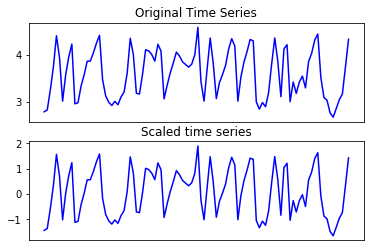

In [4]:
## Creating a function that scale and standardize a dataset
def scaling(mu,std,data):
    scaler = TimeSeriesScalerMeanVariance(mu=mu, std=std)
    return scaler.fit_transform(data)

## Running the function
dataset_scale=scaling(0,1,dataset)

## Plotting the first 100 observations to check if it worked

# Plotting the original time series
plt.figure()
plt.subplot(2, 1, 1)  # First, raw time series
plt.plot(dataset[0:100], "b-")
plt.title("Original Time Series")
plt.xticks([])

# Plotting the scaled time series
plt.subplot(2, 1, 2)  # Second, PAA
plt.plot(dataset_scale.ravel()[0:100], "b-")
plt.title("Scaled time series")
plt.xticks([])

## 2) Discretization 

Creating a Piecewise Aggregate Approximation (PAA) representation (not necessary for the sake of the code, we just used it to plot and compare with the SAX representation to validate the transformation)

In [5]:
### Firstly, creting a function that creates the PPA
def ppa(n_paa_segments,dataset_scale):
    # Number of PAA segments to compute - one segment for every 4 hours
    n_paa_segments=int(round([len(x) for x in dataset_scale][0]/4,0))
    # Creating a piecewise aggregation approximation using n_paa_segments
    paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
    # Compute paa time series corresponding (by paa.inverse_trasnform) to the fitted PAA representation (done by fit_transform)
    return  paa.inverse_transform(paa.fit_transform(dataset_scale))

### Running the function to test it for a given column of the dataset
n_paa_segments=int(round(len(dftrain1)/4,0))
paa_dataset_inv=ppa(n_paa_segments,dataset_scale)

Creating the Symbolic Aggregate Approximation (SAX)

In [6]:
### Firstly, creting a function that creates the sax
def tosax(n_paa_segments,n_sax_symbols,dataset_scale):
    #Creating the SAX using 'n_paa_segments' as number of segments and 'n_sax_symbols' as number of symbols
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
    # Compute sax time series corresponding (by sax.inverse_transform) to the fitted PAA representation (done by sax.fit_transform)
    return sax.inverse_transform(sax.fit_transform(dataset_scale))

### Running the function to test it for a given column of the dataset
n_sax_symbols = 5
sax_dataset_inv=tosax(n_paa_segments,n_sax_symbols,dataset_scale)

Plotting the scaled time series, PAA and SAX representations for the sake of validation of the code

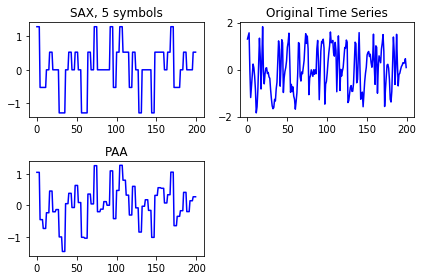

In [7]:
#Plotting - only 100 first values to test the code isworking as expected

# Plotting the scaled data set
plt.subplot(2, 2, 2)  # First, raw time series
plt.plot(dataset_scale.ravel()[300:500], "b-")
plt.title("Original Time Series")

#Plotting the PAA (ONLY FOR COMPARISON PURPOSES)
plt.subplot(2, 2, 3)  
plt.plot(paa_dataset_inv[0].ravel()[300:500], "b-")
plt.title("PAA")

#Plotting the SAX
plt.subplot(2, 2, 1)  # Then SAX
plt.plot(sax_dataset_inv[0].ravel()[300:500], "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.tight_layout()
plt.show()

## 3) Sliding Window and N-Grams Representations

Creating a function that returns its n-gram representation.

In [8]:
a=sax_dataset_inv[0].ravel()

We need function(s) to convert numeric values generated from the sax to a string to perform N-grams as a it was a NLP problem. For this purpose two functions were created: the first just put all the values of a list in a string and the second convert numerical values of the sax to letters

In [9]:
# First function convert a list of numeric values to a string
def convert(list): 
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    # Join list items using join() 
    res = ("".join(s)) 
    return(res) 

In [12]:
# Second function to convert a sax numeric representation into strings
def saxtostring(sax):
    #Creating a list with all unique elements
    setsax=set(sax)
    L=[]
    for i in setsax:
        L.append(i)
    L=sorted(L)
    #Creating a dictinary with the elements that need to be converted
    D={}
    for i in range(0,len(L)):
        D[L[i]]=string.ascii_lowercase[i]
    #Converting the numerical values to strings
    output=[]
    for i in range(0,len(sax)):
        output.append(D[sax[i]])
    return output  
#b=saxtostring(a)

Now to generate Ngrams we need a function that gather from the data the possible grams and their possible next values.

In [18]:
#Function that creates the Ngrams representation by creating a dictionary that has as keys the representations and as values
#the number elements generated after the n-gram
def tongrams(tokens,n):
    #Creates a dictionary with the Ngrams representation and the next element (that is to be predicted by the ngrams)
    D = {}
    #Loop needs to go up to len(tokens)-n-1 to not get out of bounds
    for i in range(0,len(tokens)-n-1):
        #If new key, we add this key to the dictionary
        if convert(tokens[i:(i+n)]) not in D.keys():
            D[convert(tokens[i:(i+n)])] = [convert(tokens[i+n+1])]
        #If existing key, append new value
        else:
            D[convert(tokens[i:(i+n)])].append(tokens[i+n+1])
    return D
#g=tongrams(b,3)

Now we create a Markov Chain that calculates the prior and the posterior given the dictionary generated by the previous function.

In [21]:
#Function that calcualte the likelihood given a ngram
def tomarkovchain(ngram):
    #Create dictionary to be filled with the probability of conditional events (likelihood)
    l_probs=dict()
    #Create the dictionaries to be filled with the counting for each gram
    c1=dict()
    #Loop through keys to calculate the likelihood for each key
    for key in ngram.keys():
        #Create the variable to be filled with tally of the number of times that a value repeat for each key
        counts = dict()
        for i in ngram[key]:
            counts[i] = counts.get(i, 0) + 1
        #Create the dictionary to be filled with the probability of the conditional events (likelihood)
        l=dict()

        #Calculate the probability by dividing the count to the sum of values
        for j in counts.keys():
            l[j]=counts[j]/sum(counts.values())
    
        #Assign to each key the dictionary with the probabilities
        l_probs[key]=l
        #Assign to each key the dictionary with the counting
        c1[key]=counts
    

    # Return the likelihood,the prior and the counting
    return [l_probs,c1]

#m=tomarkovchain(g)

In [22]:
#Smoothing the prior
#This function return the smoothed probability
def smooth_ngram_prob(markovchain_model,n_sax_symbols,input_gram,output_gram):
    
    #Calculating denominators
    ngrams_number=len(random.choice(list(markovchain_model[0].keys())))
    
    #Smoothing
    if input_gram in markovchain_model[1].keys():
        total_values_for_the_key=sum(markovchain_model[1][input_gram].values())
        #The Probability is calculated by adding 1 observation for all possible grams (total of n_sax_symbols**ngrams_number )
        smoothed=(markovchain_model[1][input_gram].get(output_gram,0)+1)/(total_values_for_the_key+n_sax_symbols)
    else:
        #There is no observation of this gram
        smoothed=0
        
    return smoothed

#smooth_ngram_prob(m,5,"aae","a")


0.14285714285714285

Lastly, we create a function that loop through the dataframe and return the index that are below a certain threshold

In [23]:
def prediction(markovchain_model,n_sax_symbols,string_sax, threshold):
    #Calculating number of ngrams used
    n=len(random.choice(list(markovchain_model[0].keys())))
    #Calculationg the number of times a observation should be reproduced so the data set has the same size as the original

    #Creating the list to store the values
    L=[]
    #looping
    for i in range(0,len(string_sax)):
        if (i<=(n+1)):
            L.append(0)
        else:
            if smooth_ngram_prob(markovchain_model,n_sax_symbols,convert(string_sax[i:(i+n)]),string_sax[i])<threshold:
                L.append(1)
            else:
                L.append(0)
    return L

And a function that merge the predictions into the original dataframe considering the possible rounding differences when creating SAX

In [89]:
def smartmerge(df,predictions):
    df=pd.Series.to_frame(df)
    if len(predictions)==len(df):
        df.insert(1, "predictions", predictions)
        df.reset_index(inplace=True)
    if len(predictions)>len(df):
        predictions=predictions[:-(len(predictions)-len(df))]
        df.insert(1, "predictions", predictions)
        df.reset_index(inplace=True)
    if len(predictions)<len(df):
        for i in range(0,(len(df)-len(predictions))):
            predictions.append(0)
        df.insert(1, "predictions", predictions)
        df.reset_index(inplace=True)
    return df        

## 4) Predictions Attacks Using N-grams

_In this subchapter we are going to try to predict the attacks on the training dataset 2_

### Attack 1

Variables affected by attack1 - F_PU10 and L_T7

In [25]:
def plot_attack (column):
    plt.figure(figsize = (10, 5))
    attack1=dftrain2.loc[:,column]
    attack1[datetime.datetime(2016, 9, 8,0):datetime.datetime(2016, 9, 13,23)].plot(color='blue')
    attack1[datetime.datetime(2016, 9, 13,23):datetime.datetime(2016, 9, 16,0)].plot(color='red')
    attack1[datetime.datetime(2016, 9, 16,0):datetime.datetime(2016, 9, 21,0)].plot(color='blue')
    plt.title(column)

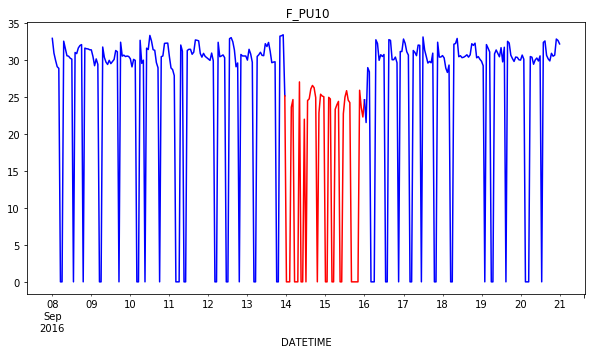

In [26]:
# plot 1
plot_attack(" F_PU10")

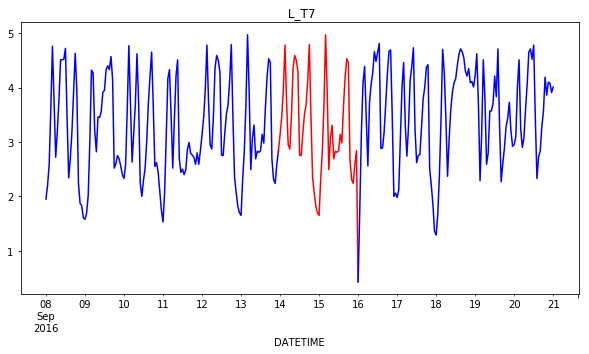

In [27]:
# plot 2
plot_attack(' L_T7')

Predicting attack for F_PU10

In [28]:
#Generating the model
df1=dftrain2[" F_PU10"]
#Scaling
s=scaling(0,1,df1)
#Sax
n_sax_symbols=5
n_paa_segments=int(round(len(dftrain2)/4,0))
sax=tosax(n_paa_segments,n_sax_symbols,s).ravel()
#Sax to string
sax_string=saxtostring(sax)
#Ngrams
n=3
ngrams=tongrams(sax_string,n)
#Markov Chain
m=tomarkovchain(ngrams)

In [65]:
#Calculating the probability
threshold=0.001
pred=prediction(m,n_sax_symbols,sax_string, threshold)

In [66]:
df1=dftrain2[" F_PU10"]
df=pd.Series.to_frame(df1)
predictions=pred

In [67]:
test=smartmerge(df1,pred)

In [72]:
test.head()

,F_PU10,predictions
DATETIME,,
2016-07-04 00:00:00,29.87,0
2016-07-04 01:00:00,0.00,0
2016-07-04 02:00:00,0.00,0
2016-07-04 03:00:00,32.68,0
2016-07-04 04:00:00,32.81,0


In [82]:
test.reset_index(inplace=True)

In [91]:
plt.figure(figsize = (10, 5))
test[(test['DATETIME'] >= datetime.datetime(2016, 9, 8,0)) & (test['DATETIME'] >= datetime.datetime(2016, 9, 21,0))&
     (test['predictions']==0)].plot(color="blue")
test[(test['DATETIME'] >= datetime.datetime(2016, 9, 8,0)) & (test['DATETIME'] >= datetime.datetime(2016, 9, 21,0))&
     (test['predictions']==1)].plot(color="red")

IndentationError: unexpected indent (<ipython-input-91-e138c3cf76ca>, line 3)

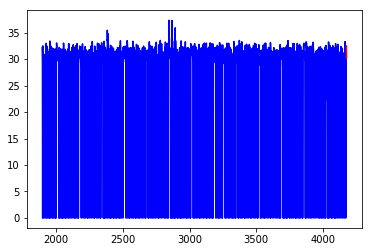

In [99]:
test[(test['DATETIME'] >= datetime.datetime(2016, 9, 8,0)) & (test['DATETIME'] >= datetime.datetime(2016, 9, 21,0))&
     (test['predictions']==0)][' F_PU10'].plot(color='blue')
test[(test['DATETIME'] >= datetime.datetime(2016, 9, 8,0)) & (test['DATETIME'] >= datetime.datetime(2016, 9, 21,0))&
     (test['predictions']==1)][' F_PU10'].plot(color='red')